In [123]:
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,mean_squared_error, confusion_matrix, accuracy_score,roc_auc_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [88]:
df=pd.read_csv("D:/ACCIO/Capstone ML Project/Data/kz.csv")

In [89]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2633521 entries, 0 to 2633520
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   order_id       int64  
 2   product_id     int64  
 3   category_id    float64
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        float64
dtypes: float64(3), int64(2), object(3)
memory usage: 160.7+ MB


In [4]:
df.shape

(2633521, 8)

In [29]:
#Checking the Null percentage
df.isnull().mean()*100

event_time       0.0
order_id         0.0
product_id       0.0
category_id      0.0
category_code    0.0
brand            0.0
price            0.0
user_id          0.0
Segment          0.0
Sub-Segment      0.0
hour             0.0
dtype: float64

In [30]:
#COnverting Null values 
df['category_code']=df['category_code'].fillna('Unknown')
df['brand']=df['brand'].fillna('Unknown')
df['price']=df['price'].fillna(df['price'].median())
df['category_id']=df['category_id'].fillna(-1)
df['user_id']=df['user_id'].fillna(-1)


In [31]:
# Converting datatypes
df['event_time']=pd.to_datetime(df['event_time'],errors='coerce')
df['order_id']=pd.to_numeric(df['order_id'],errors='coerce')
df['category_id']=df['category_id'].astype('int64')
df['user_id']=df['user_id'].astype('int64')



In [32]:
df.describe()

,order_id,product_id,category_id,price,user_id,hour
count,2.052768e+06,2.052768e+06,2.052768e+06,2.052768e+06,2.052768e+06,2.052768e+06
mean,2.362211e+18,1.702292e+18,2.273930e+18,1.607139e+02,3.889417e+17,9.102514e+00
std,1.739919e+16,3.288598e+17,2.370626e+16,2.457070e+02,6.620629e+17,3.340705e+00
min,2.294360e+18,1.515966e+18,2.268105e+18,0.000000e+00,-1.000000e+00,0.000000e+00
25%,2.348809e+18,1.515966e+18,2.268105e+18,1.734000e+01,-1.000000e+00,7.000000e+00
50%,2.353258e+18,1.515966e+18,2.268105e+18,6.248000e+01,-1.000000e+00,9.000000e+00
75%,2.383856e+18,1.515966e+18,2.268105e+18,2.083100e+02,1.515916e+18,1.100000e+01
max,2.388441e+18,2.388434e+18,2.374499e+18,5.092590e+04,1.515916e+18,2.300000e+01


In [33]:
# Bifurcating Category_Code to Segment and Sub_Segment and merging sub-segment 
df['Segment']=df['category_code'].apply(lambda x : x.split('.')[0] if isinstance(x,str) and not x.isdigit() else "Unknown")
df['Sub-Segment']=df['category_code'].apply(lambda x : x.split('.')[1] if isinstance(x,str) and '.' in x and len(x.split('.'))>1 else "Unknown")
df['Sub-Segment2']=df['category_code'].apply(lambda x : x.split('.')[2] if isinstance(x,str) and '.' in x and len(x.split('.'))>2 else "Unknown")
df['Sub-Segment']=df['Sub-Segment'] +'-'+ df['Sub-Segment2']
df['Sub-Segment'] = df['Sub-Segment'].replace('Unknown-Unknown', 'Unknown')
df.drop(['Sub-Segment2'],axis=1,inplace=True)
df['Sub-Segment'] = df['Sub-Segment'].apply(lambda x: x.split('-')[0] if 'Unknown' in x else x)


In [34]:
df.shape

(2052768, 11)

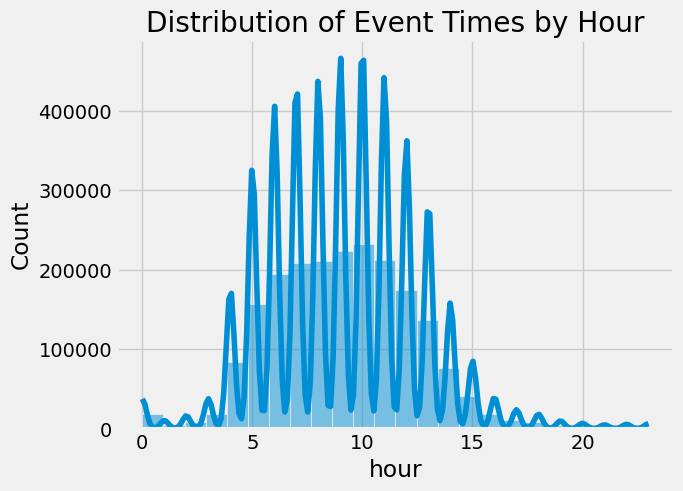

In [35]:
#distribution
df['hour'] = df['event_time'].dt.hour
sns.histplot(df['hour'], bins=24, kde=True)
plt.title('Distribution of Event Times by Hour')
plt.show()


In [12]:
#distribution
order_counts=df['order_id'].nunique()
print(f"Total number of orders:{order_counts}")

Total number of orders:1435266


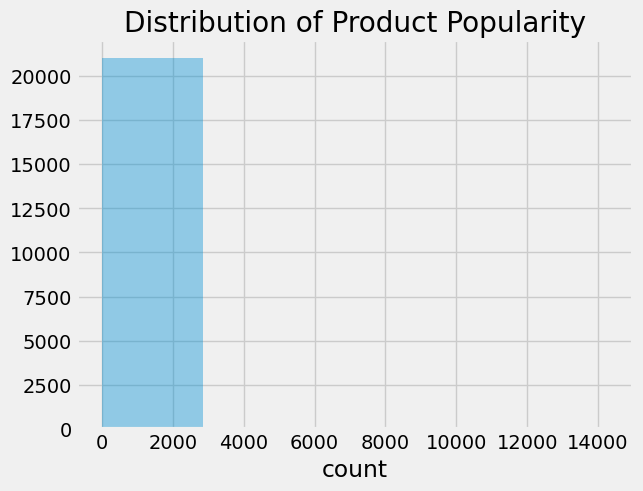

In [36]:
prod_counts=df['product_id'].value_counts()
sns.distplot(prod_counts,bins=5,kde=False)
plt.title('Distribution of Product Popularity')
plt.show()

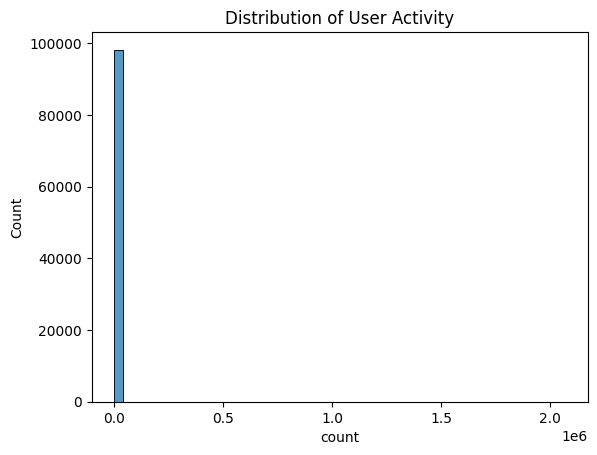

In [14]:
user_counts = df['user_id'].value_counts()
sns.histplot(user_counts, bins=50, kde=False)
plt.title('Distribution of User Activity')
plt.show()


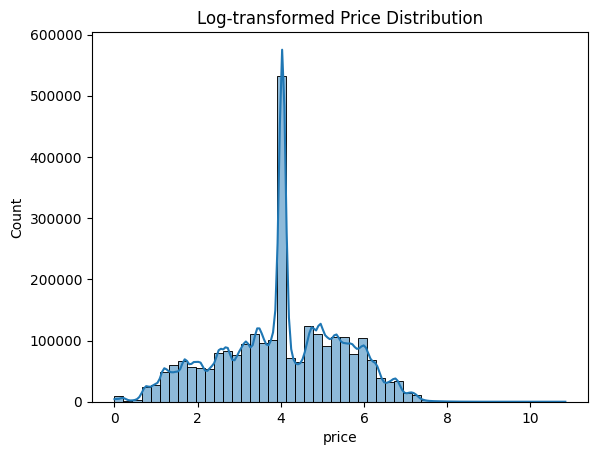

In [15]:
import numpy as np
sns.histplot(np.log1p(df['price']), bins=50, kde=True)
plt.title('Log-transformed Price Distribution')
plt.show()


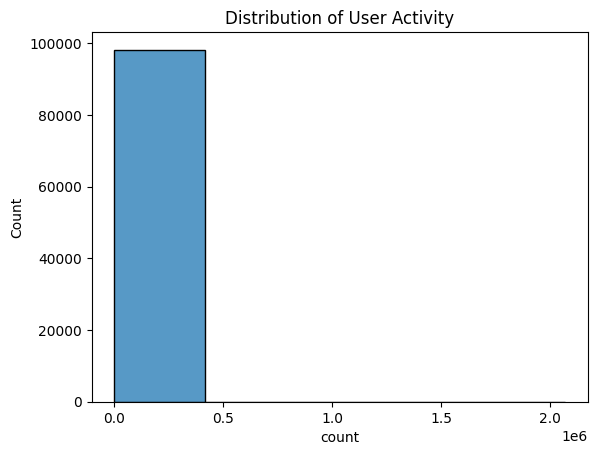

In [16]:
user_counts = df['user_id'].value_counts()
sns.histplot(user_counts, bins=5, kde=False)
plt.title('Distribution of User Activity')
plt.show()


In [37]:
num_col = []
cat_col = []
datetime_col = []

for i in df.columns:
    if df[i].dtypes == 'O':
        cat_col.append(i)
    elif df[i].dtypes == 'datetime64[ns, UTC]':
        datetime_col.append(i)
    else:
        num_col.append(i)

print("Numerical Columns are:", num_col)
print("Categorical Columns are:", cat_col)
print("Datetime Columns are:", datetime_col)

    


Numerical Columns are: ['order_id', 'product_id', 'category_id', 'price', 'user_id', 'hour']
Categorical Columns are: ['category_code', 'brand', 'Segment', 'Sub-Segment']
Datetime Columns are: ['event_time']


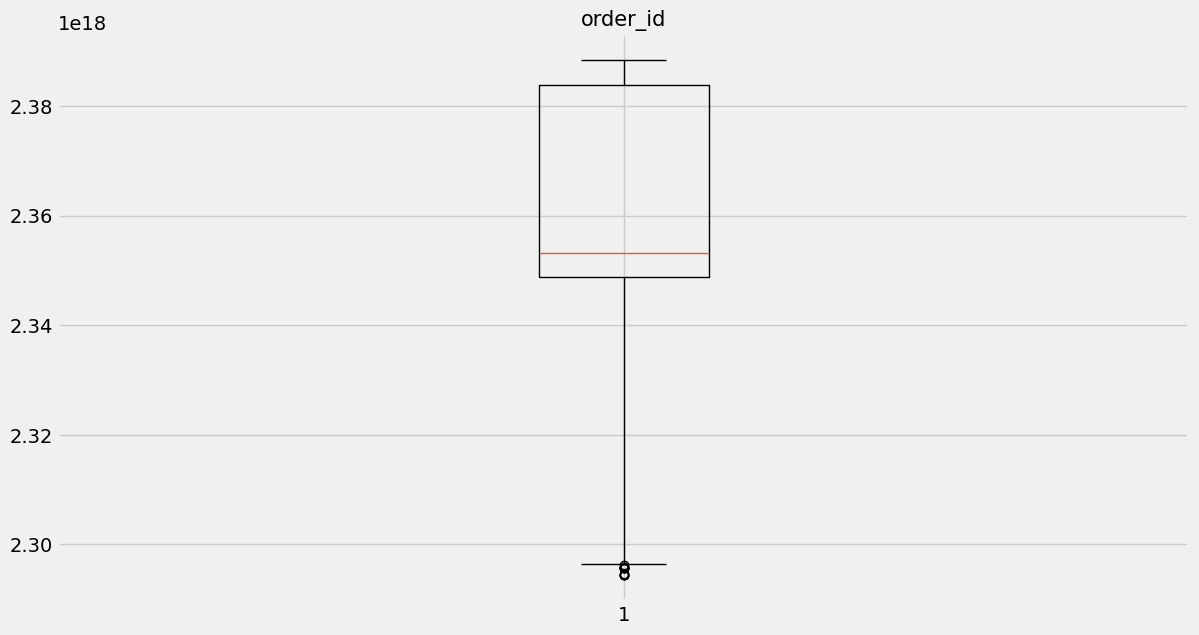

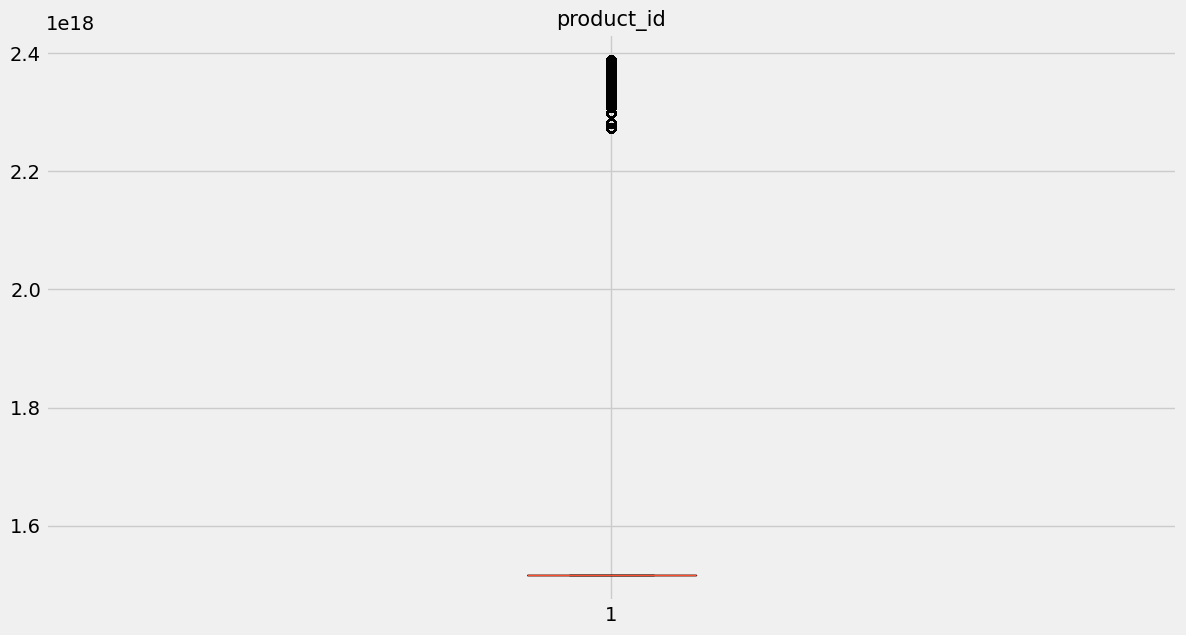

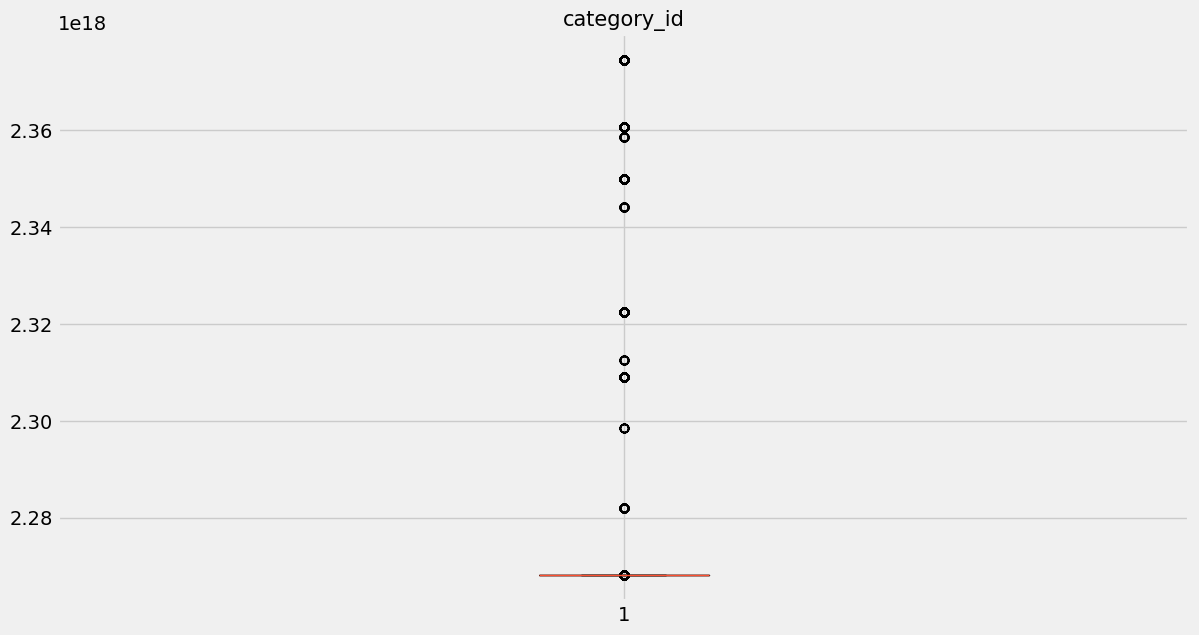

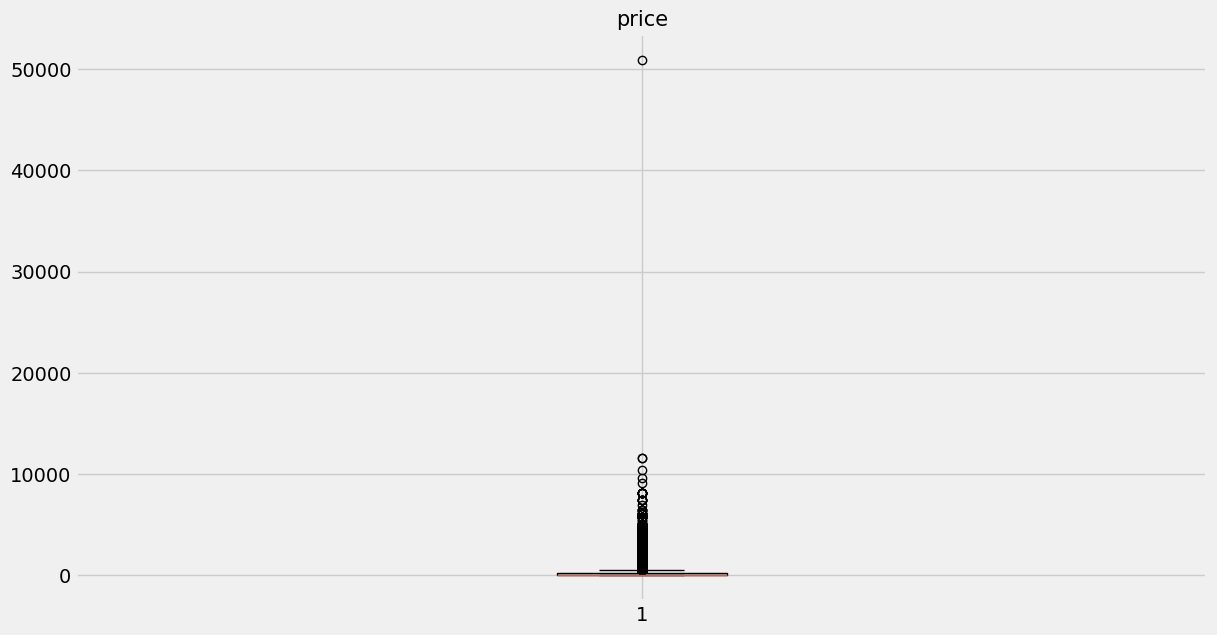

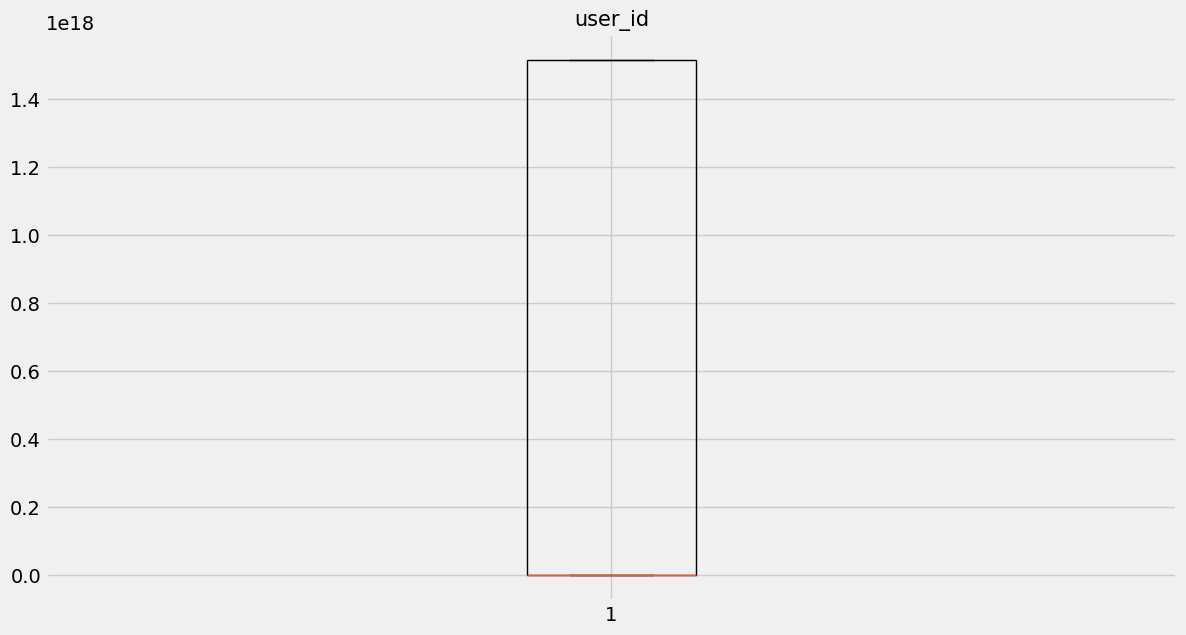

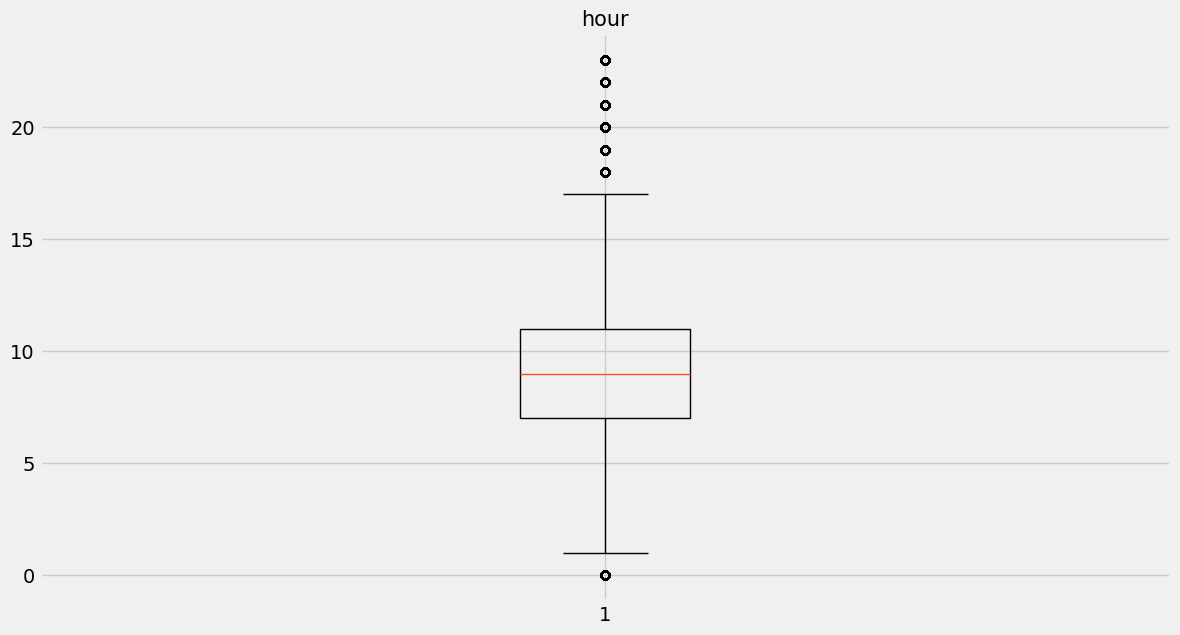

In [38]:
# Boxplot for numeric columns
for i in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(13,7))
    plt.style.use('fivethirtyeight')
    plt.boxplot(df[i])
    plt.title(i, fontsize=15)
    plt.show()


Text(0.5, 1.0, 'Correlation Between Numerical Features')

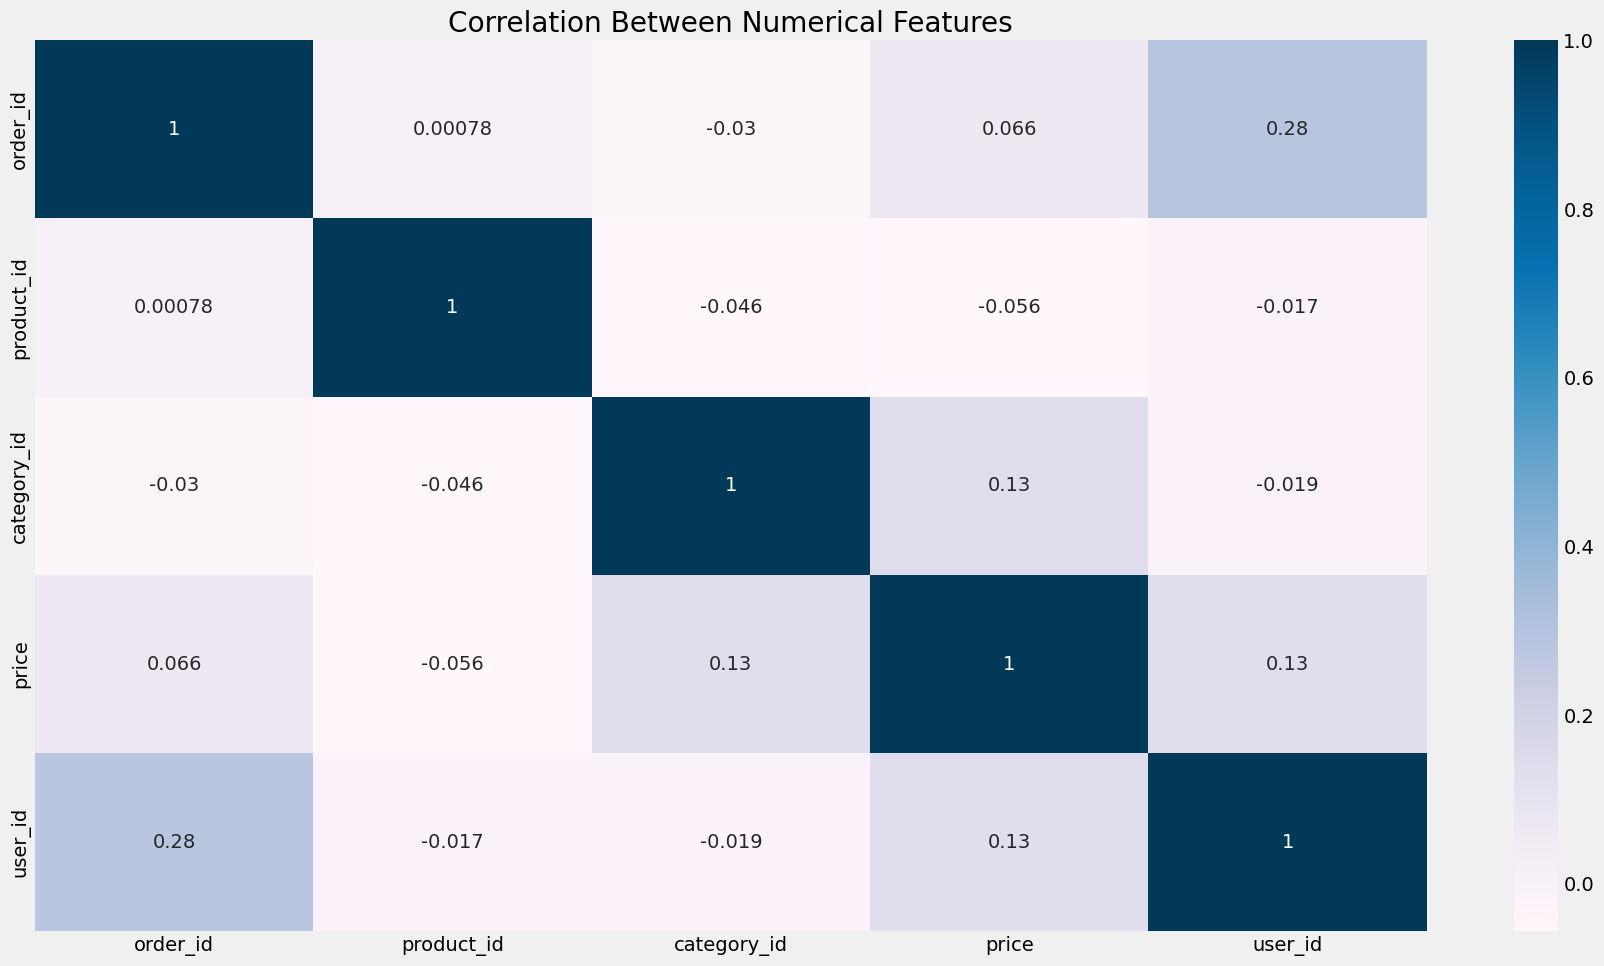

In [39]:
numeric_columns = df.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(20,11))
sns.heatmap(numeric_columns.corr(),annot=True,cmap='PuBu')
plt.title("Correlation Between Numerical Features")

In [20]:
df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,Segment,Sub-Segment,hour
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2268105426648171008,electronics.tablet,samsung,162.01,1515915625441993984,electronics,tablet,11
1,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2268105426648171008,electronics.tablet,samsung,162.01,1515915625441993984,electronics,tablet,11
2,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2268105430162997760,electronics.audio.headphone,huawei,77.52,1515915625447879424,electronics,audio-headphone,14
3,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2268105430162997760,electronics.audio.headphone,huawei,77.52,1515915625447879424,electronics,audio-headphone,14
4,2020-04-24 19:16:21+00:00,2294584263154074236,2273948316817424439,2268105471367840000,Unknown,karcher,217.57,1515915625443148032,Unknown,Unknown,19


In [40]:
unique=df.drop_duplicates()
print(len(unique))
print(df)

2052150
                       event_time             order_id           product_id  \
0       2020-04-24 11:50:39+00:00  2294359932054536986  1515966223509089906   
1       2020-04-24 11:50:39+00:00  2294359932054536986  1515966223509089906   
2       2020-04-24 14:37:43+00:00  2294444024058086220  2273948319057183658   
3       2020-04-24 14:37:43+00:00  2294444024058086220  2273948319057183658   
4       2020-04-24 19:16:21+00:00  2294584263154074236  2273948316817424439   
...                           ...                  ...                  ...   
2633516 2020-11-21 10:10:01+00:00  2388440981134693942  1515966223526602848   
2633517 2020-11-21 10:10:13+00:00  2388440981134693943  1515966223509089282   
2633518 2020-11-21 10:10:30+00:00  2388440981134693944  1515966223509089917   
2633519 2020-11-21 10:10:30+00:00  2388440981134693944  2273948184839454837   
2633520 2020-11-21 10:10:30+00:00  2388440981134693944  1515966223509127566   

                 category_id               

#Problem Statement
1.What is the total revenue generated by each product segment?
Explanation: Analyze how much revenue each product category contributes to the overall revenue. This helps identify high-performing product categories.

In [41]:
df_filtered=df[df['Segment'].str.match('^[A-Za-z]+$',na=False)]
result=df_filtered.groupby(['Segment','Sub-Segment'])['price'].sum().reset_index()
result['price']=result['price'].astype('int64')
result = result.sort_values(by='price', ascending=False).reset_index(drop=True)
print(result)

          Segment            Sub-Segment      price
0     electronics             smartphone  102611995
1         Unknown                Unknown   32060905
2       computers               notebook   31347333
3      appliances  kitchen-refrigerators   30182823
4     electronics               video-tv   29269587
..            ...                    ...        ...
115  construction            tools-light        238
116          kids           fmcg-diapers        203
117   electronics             calculator        203
118         sport                 diving        109
119       apparel                costume         42

[120 rows x 3 columns]


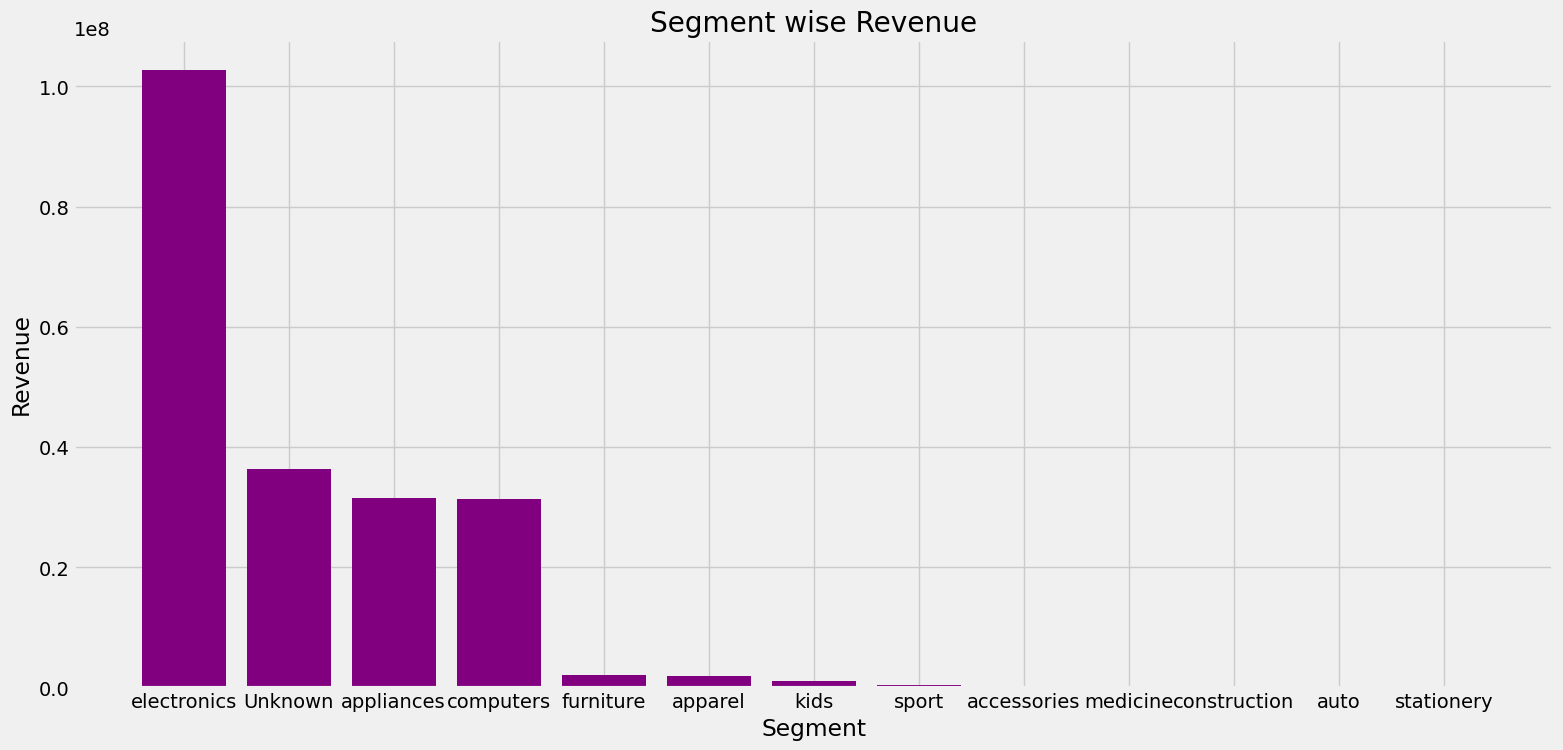

In [23]:
plt.figure(figsize=(17,8))
plt.bar(result['Segment'],result['price'],color='Purple')
plt.title("Segment wise Revenue")
plt.xlabel("Segment")
plt.ylabel("Revenue")
plt.show()

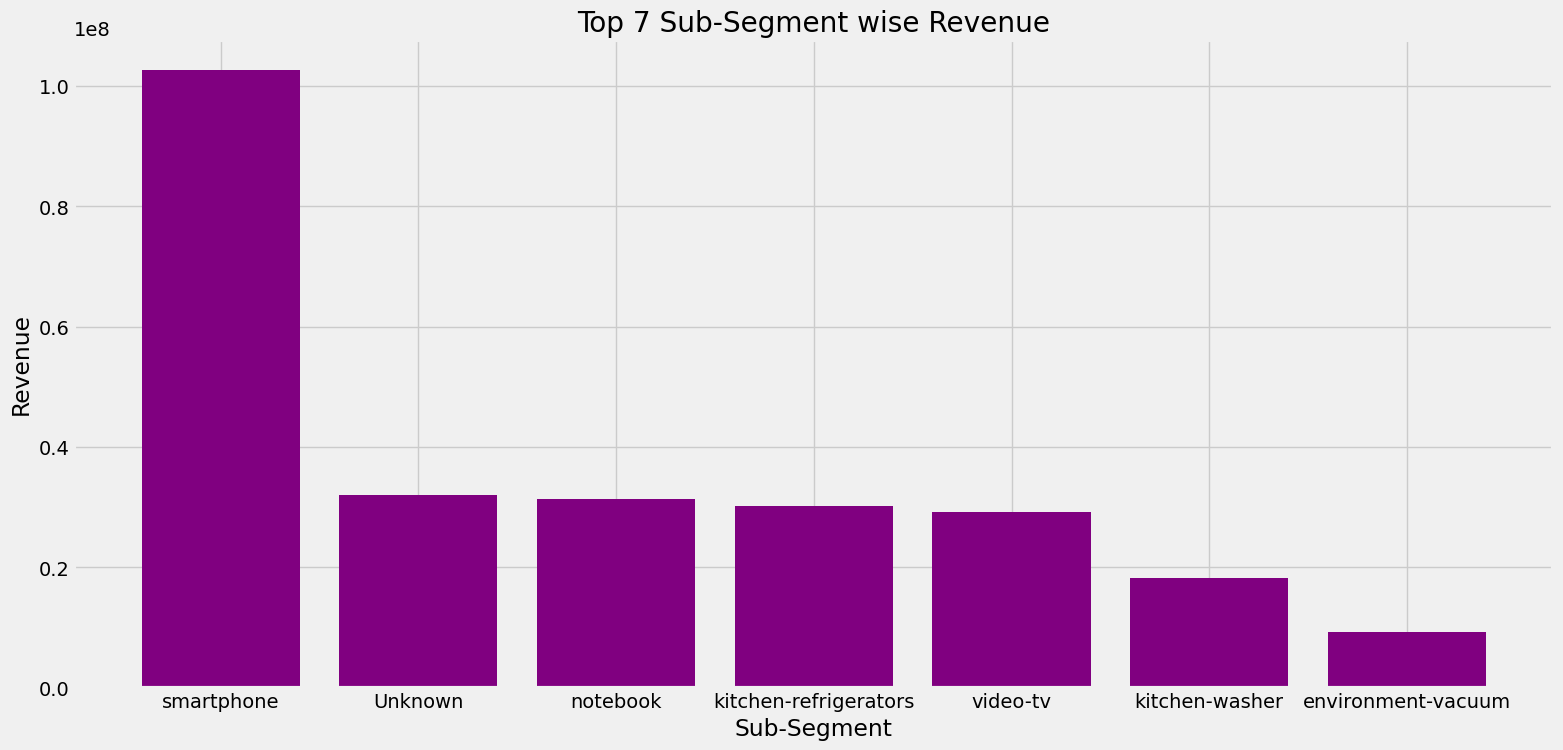

In [42]:
top7=result.sort_values(by='price', ascending=False).head(7)
plt.figure(figsize=(17,8))
plt.bar(top7['Sub-Segment'],top7['price'],color='Purple')
plt.title("Top 7 Sub-Segment wise Revenue")
plt.xlabel("Sub-Segment")
plt.ylabel("Revenue")
plt.show()

Electronics.Smartphone is the most revenue generating segment.

2.What is the most frequently purchased product category?
Explanation: Count the number of times each product category appears in the dataset to determine popularity.

In [43]:
filtered_df = df.loc[(df['Segment'] != 'Unknown')&(df['Segment'].str.match('^[A-Za-z]+$',na=False))]
result=filtered_df.groupby(['Segment','Sub-Segment']).size().reset_index(name='count')
result = result.sort_values(by='count', ascending=False).reset_index(drop=True)
print(result)

         Segment            Sub-Segment   count
0    electronics             smartphone  352554
1     appliances  kitchen-refrigerators   74066
2    electronics               video-tv   71709
3      computers               notebook   71232
4     appliances     environment-vacuum   66231
..           ...                    ...     ...
114         kids                  swing       8
115  accessories               umbrella       4
116        sport              snowboard       3
117      apparel                  shoes       2
118      apparel                costume       2

[119 rows x 3 columns]


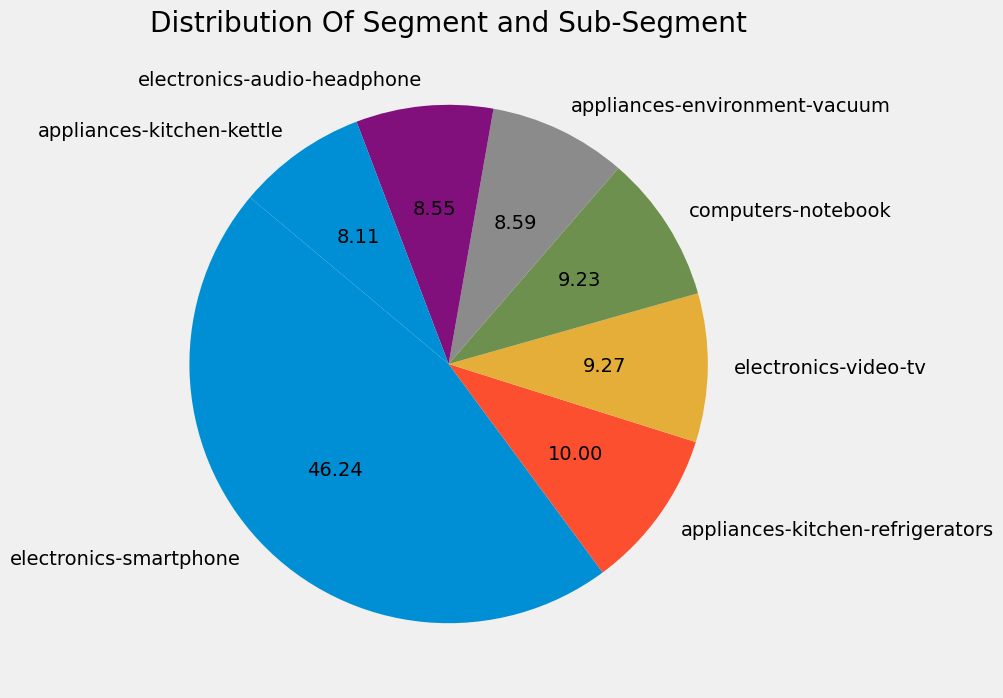

In [26]:
top7=result.sort_values(by='count',ascending=False).head(7)
plt.figure(figsize=(17,8))
plt.pie(top7['count'],labels=top7['Segment']+'-'+top7['Sub-Segment'],autopct='%.2f',startangle=140)
plt.title("Distribution Of Segment and Sub-Segment")
plt.show()

3.What is the distribution of orders by brand?
Explanation:Determine how sales are distributed across different brands to find dominant ones.


In [51]:
df=df.loc[(df['brand']!='Unknown')&(df['brand'].str.match('^[A-Za-z]+$',na=False))]
res=df.groupby(['brand'])['order_id'].size().reset_index()
res=res.sort_values(by='order_id',ascending=False).reset_index(drop=True).head(7)
print(res)

     brand  order_id
0  samsung    358928
1      ava    118161
2    tefal     78653
3    apple     74709
4   huawei     57438
5       lg     55685
6  philips     52327


In [53]:
plt.figure(figsize=(17,8))
plt.bar(top7['brand'],top7['order_id'],color='Red')
plt.title('Top7 Brand wise Orders')
plt.xlabel('Brand')
plt.ylabel('Orders')
plt.show()

KeyError: 'brand'

<Figure size 1700x800 with 0 Axes>

Samsung leads with the highest order count.

4.What is the average price of products by category?
Explanation: Calculate the mean price for products in each category to identify premium categories.


In [54]:
res=df.groupby(['category_code'])['price'].mean().reset_index()
res=res.sort_values(by='price',ascending=False).reset_index(drop=True)
print(res)

                     category_code       price
0         electronics.camera.video  620.713450
1                computers.desktop  529.675035
2         electronics.camera.photo  505.818067
3        construction.tools.heater  503.302107
4    appliances.kitchen.dishwasher  500.390575
..                             ...         ...
119          furniture.bedroom.bed    8.202643
120   auto.accessories.anti_freeze    7.733482
121          country_yard.watering    5.764000
122               stationery.paper    4.142107
123             stationery.battery    3.202756

[124 rows x 2 columns]


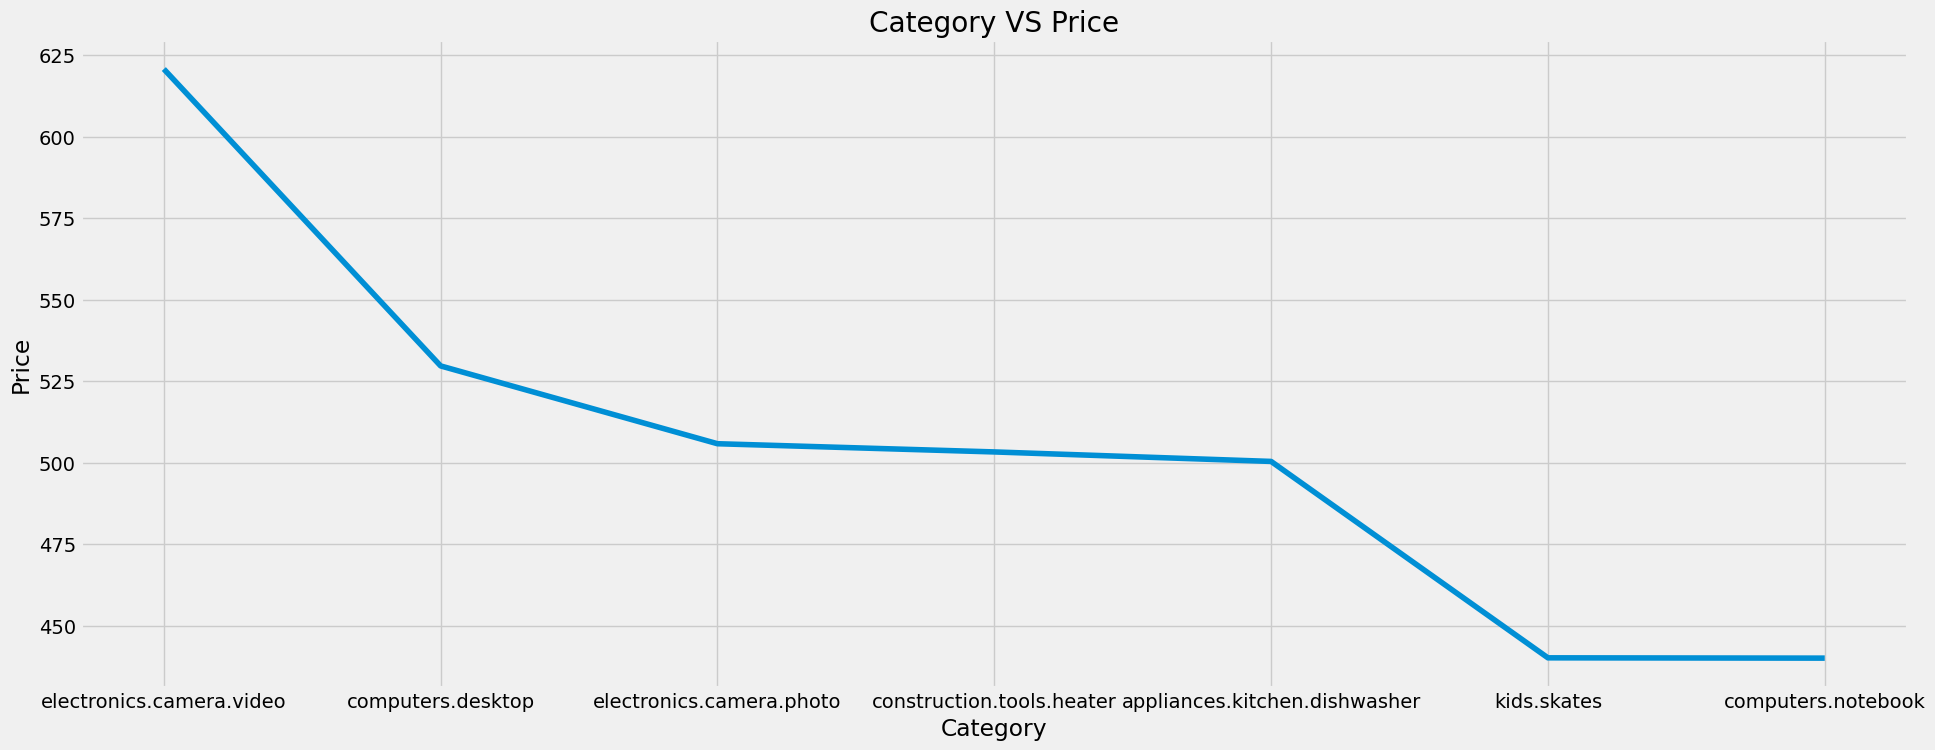

In [55]:
top7=res.sort_values(by='price',ascending= False).head(7)
plt.figure(figsize=(21,8))
plt.plot(top7['category_code'],top7['price'])
plt.xlabel("Category")  
plt.ylabel("Price")
plt.title("Category VS Price")
plt.show()


"electronics.camera.video" has the highest average price.

5.Which user has the highest total spending?
Explanation: Sum the spending of each user to identify the top spender.

In [56]:
df=df.loc[(df['user_id'] != -1)]
res=df.groupby('user_id')['price'].sum().reset_index()
print(res)

                   user_id    price
0      1515915625439952128   416.64
1      1515915625440038400    56.43
2      1515915625440051456  7489.53
3      1515915625440099840  4929.86
4      1515915625440121600   182.83
...                    ...      ...
96317  1515915625514887424   208.31
96318  1515915625514887936  3472.20
96319  1515915625514888704   752.49
96320  1515915625514891008   925.67
96321  1515915625514891264   418.96

[96322 rows x 2 columns]


In [57]:
top_spender=res.sort_values(by='price',ascending= False).head()
print(top_spender)

                   user_id      price
92140  1515915625512763648  120262.62
92141  1515915625512763904  107384.13
92289  1515915625512817152  100121.65
92290  1515915625512817408   93571.32
94249  1515915625513695744   88599.50


In [58]:
x=top_spender.iloc[0]
x=x.astype('int64')
print(x)

user_id    1515915625512763648
price                   120262
Name: 92140, dtype: int64


6.What is the total revenue generated by each brand?
Explanation: Sum revenue for each brand to identify the most profitable brands.

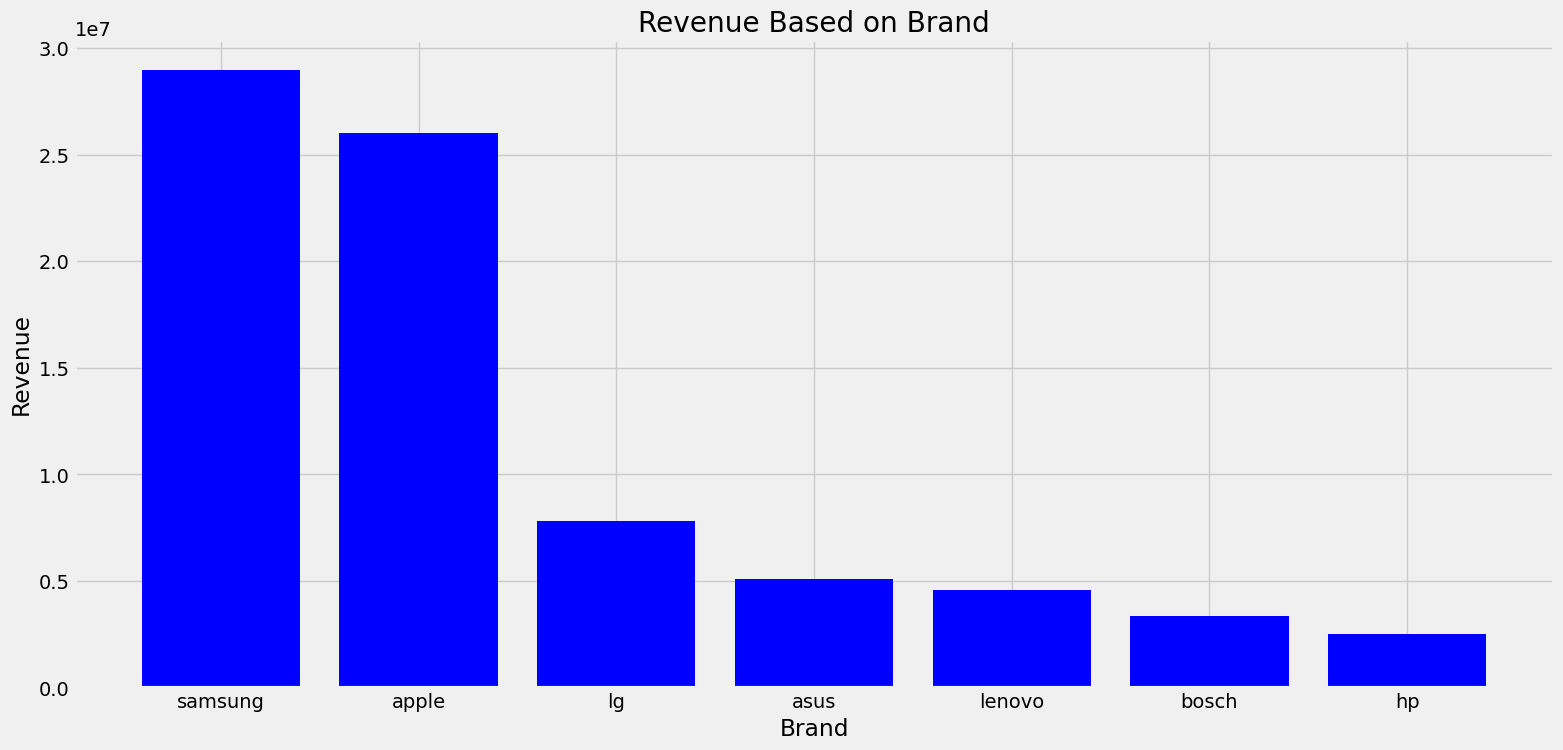

In [59]:
total_rev=df.groupby('brand')['price'].sum().reset_index()
total_rev=total_rev.sort_values(by='price',ascending=False).reset_index(drop=True).head(7)
plt.figure(figsize=(17,8))
plt.bar(total_rev['brand'],total_rev['price'],color='Blue')
plt.title("Revenue Based on Brand")
plt.xlabel("Brand")
plt.ylabel("Revenue")
plt.show()


Sansung have the highest revenue.

7.How are sales distributed across dates?
Explanation: Aggregate sales by date to identify trends in sales activity.

     event_date  price
292  2020-10-22   8147
319  2020-11-18   7676
320  2020-11-19   7452
298  2020-10-28   7211
304  2020-11-03   7164
315  2020-11-14   7011
308  2020-11-07   6540


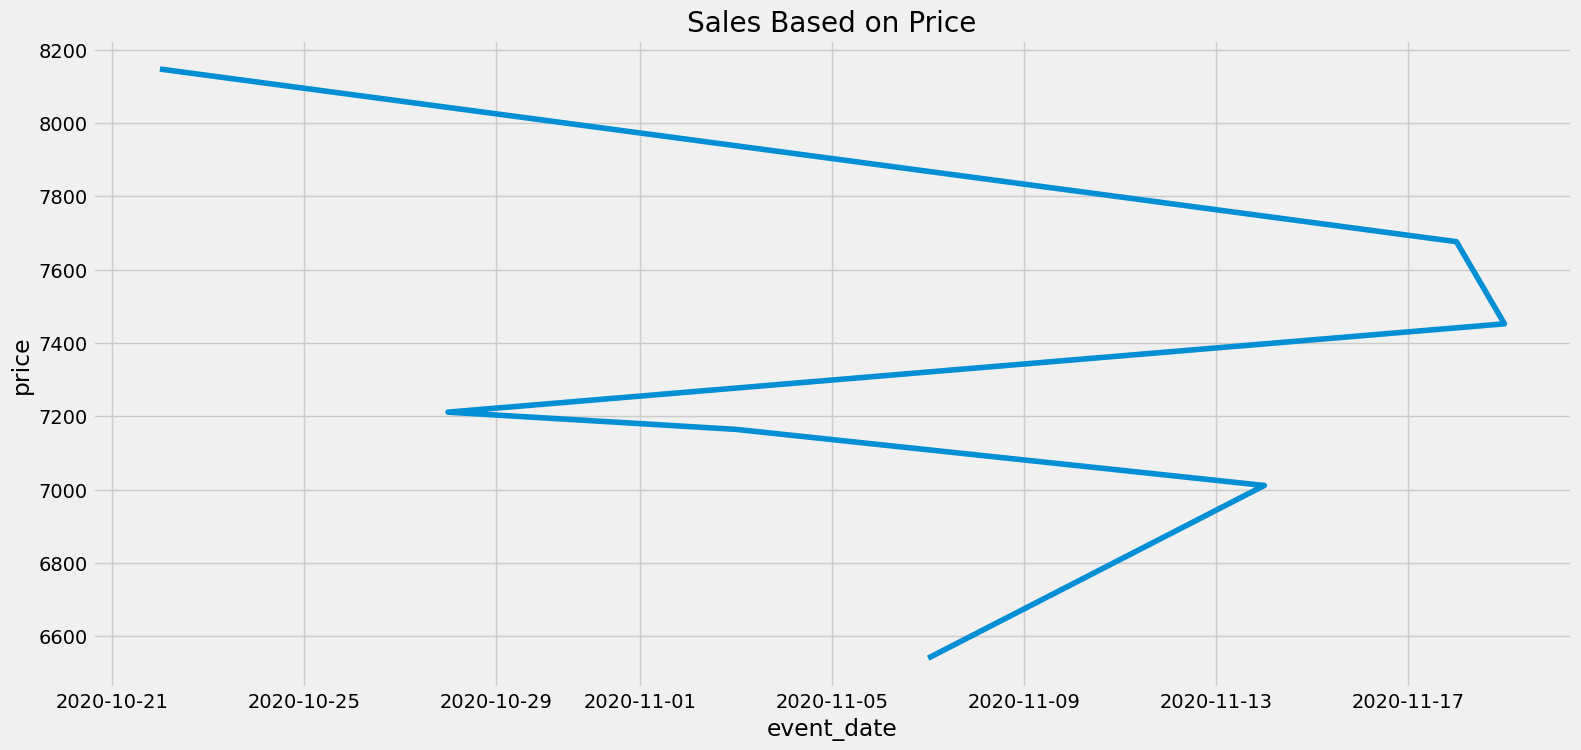

In [60]:
df['event_date']=pd.to_datetime(df['event_time']).dt.date
sales_by_date=df.groupby('event_date')['price'].size().reset_index()
top7=sales_by_date.sort_values(by='price',ascending=False).head(7)
print(top7)
plt.figure(figsize=(17,8))
plt.plot(top7['event_date'],top7['price'])
plt.title("Sales Based on Price")
plt.xlabel("event_date")
plt.ylabel("price")
plt.show()




Sales peaked at '2020-10-22'.

8.What is the most expensive product by brand?
Explanation: Identify the product with the highest price for each brand.

In [61]:
exp_prod=df.loc[df.groupby(['brand','product_id'])['price'].idxmax(),['brand','product_id','price']]
exp_prod=exp_prod.sort_values(by='price',ascending=False).reset_index(drop=True).head(1)
print(exp_prod)

  brand           product_id     price
0    lg  2273948305316643078  11574.05


LG with the product_id 2273948305316643078 has the priceiest product.

9.What is the least purchased category?
Explanation: Find the category with the lowest purchase count to identify underperforming segments.

In [62]:
filtered_df = df.loc[(df['Segment'] != 'Unknown')&(df['Segment'].str.match('^[A-Za-z]+$',na=False))]
result=filtered_df.groupby(['Segment','Sub-Segment']).size().reset_index(name='count')
result = result.sort_values(by='count', ascending=True).reset_index(drop=True).head(1)
print(result)

   Segment Sub-Segment  count
0  apparel     costume      2


Apparel with the costume product has been purchased least.

10.What is the average revenue per order?
Explanation: Dividing total revenue by total orders shows profitability per transaction.

In [63]:
total_revenue = df["price"].sum()
unique_orders = df["order_id"].nunique()
average_revenue_per_order = total_revenue / unique_orders
print("The number of unique orders",average_revenue_per_order)

The number of unique orders 298.04601750866686


11.Which category generates the highest revenue per purchase?
Explanation: Calculate revenue per purchase by dividing total revenue by purchase count for each category.

In [64]:
category_code_stats=df.groupby('category_code')['price'].agg(total_revenue='sum',purchase_count='count').reset_index()
category_code_stats['revenue_per_purchase']=category_code_stats['total_revenue']/category_code_stats['purchase_count']
highest_revenue_category=category_code_stats.loc[category_code_stats['revenue_per_purchase'].idxmax()]
print(category_code_stats)
print("\nCategory with the highest revenue per purchase:")
print(highest_revenue_category)

            category_code  total_revenue  purchase_count  revenue_per_purchase
0                 Unknown     8171969.11          114577             71.322945
1         accessories.bag       62425.32            3025             20.636469
2    accessories.umbrella         621.90               4            155.475000
3         apparel.costume          42.77               2             21.385000
4           apparel.glove      767497.74            1959            391.780368
..                    ...            ...             ...                   ...
119         sport.trainer       36538.34              84            434.980238
120    stationery.battery       18182.20            5218              3.484515
121   stationery.cartrige       36764.16            2428             15.141746
122      stationery.paper        4089.23             937              4.364173
123    stationery.stapler        2815.46              89             31.634382

[124 rows x 4 columns]

Category with the highest r

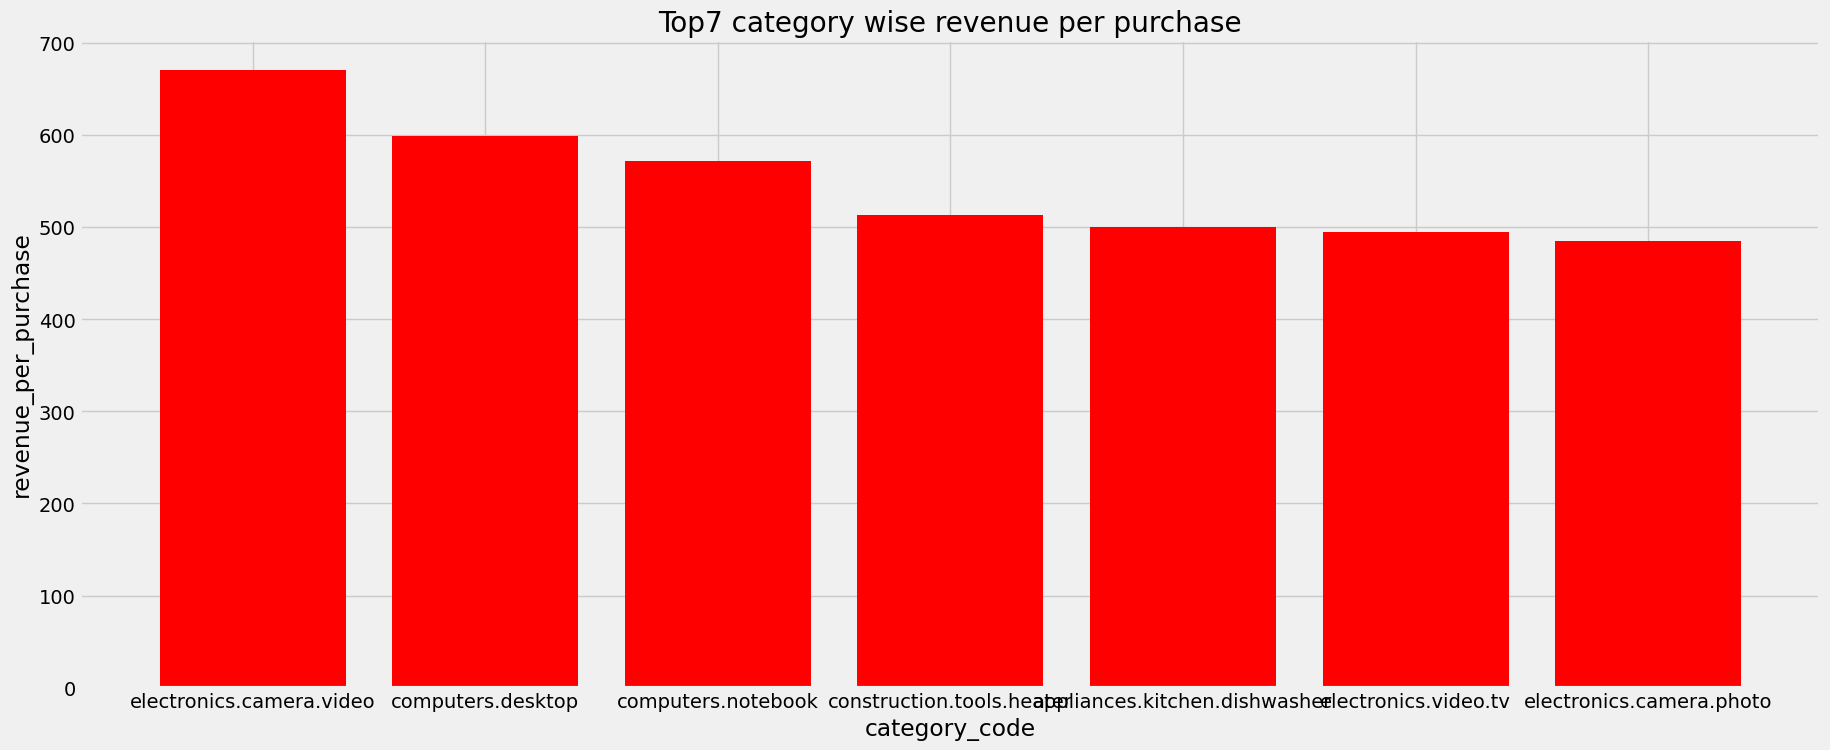

In [65]:
category_code_stats=category_code_stats.loc[(category_code_stats['category_code']!='Unknown')]
top7=category_code_stats.sort_values(by='revenue_per_purchase',ascending=False).head(7)
plt.figure(figsize=(20,8))
plt.bar(top7['category_code'],top7['revenue_per_purchase'],color='Red')
plt.title('Top7 category wise revenue per purchase')
plt.xlabel('category_code')
plt.ylabel('revenue_per_purchase')
plt.show()

electronics.camera.video provides for the highest revenue per purchase

12.Which brand has the most diverse category presence?
Explanation: Count the unique categories associated with each brand to measure diversity.

In [66]:
unique_cat= df.groupby('brand')['category_code'].count().reset_index()
unique_cat=unique_cat.sort_values(by='category_code',ascending=False).reset_index(drop=True).head(7)
print(unique_cat)

     brand  category_code
0  samsung          96239
1    apple          36084
2      ava          26123
3    tefal          17956
4       lg          16696
5   xiaomi          14881
6  philips          12151


Text(0.5, 1.0, 'Category_code vs Brand')

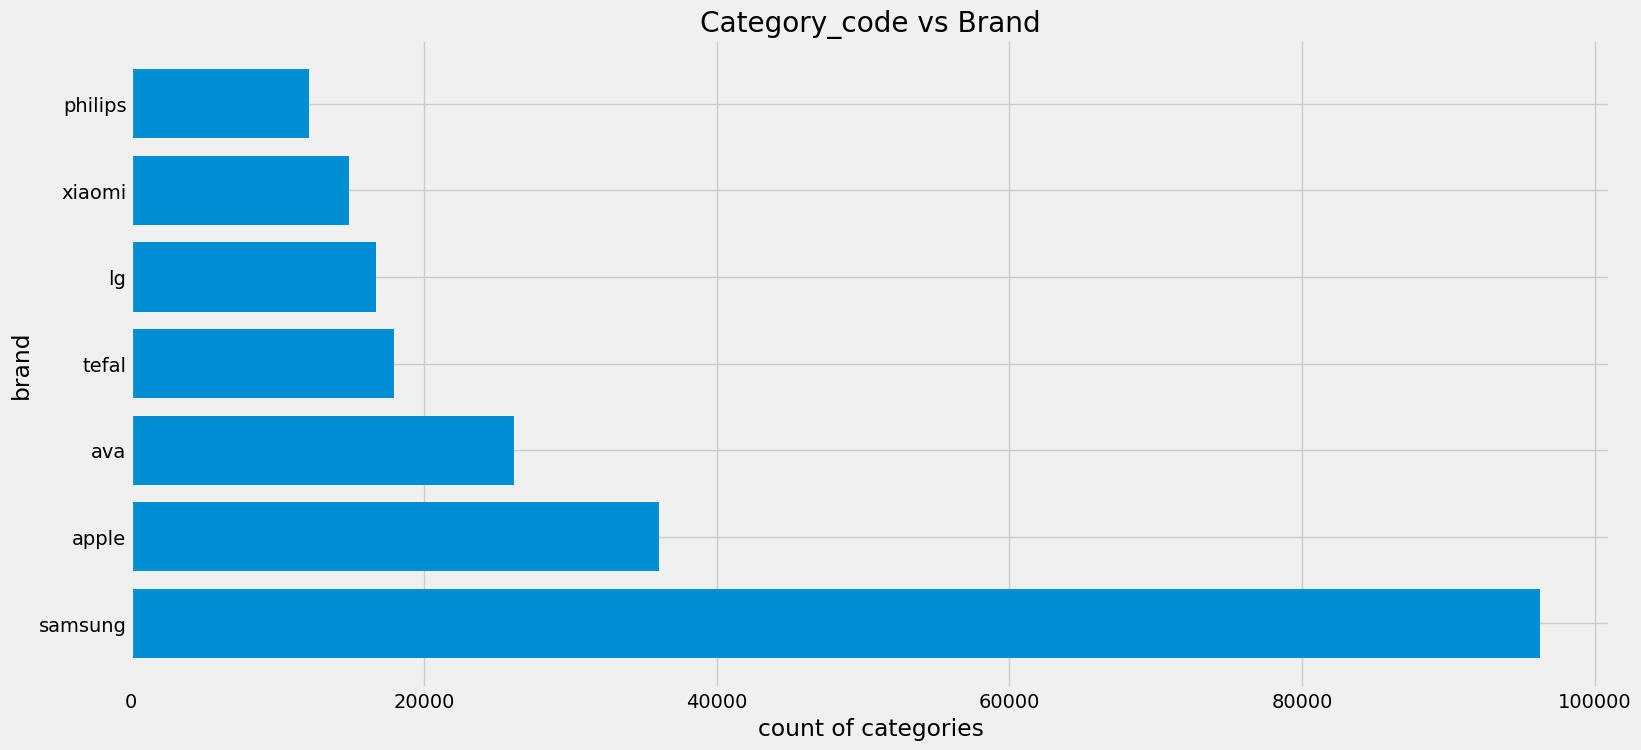

In [67]:
plt.figure(figsize=(17,8))
plt.barh(unique_cat['brand'],unique_cat['category_code'])
plt.xlabel("count of categories")
plt.ylabel("brand")
plt.title("Category_code vs Brand")

Samsung spans the most categories.

13.What percentage of total sales are accounted for by the top 3 brands?
Explanation: Calculate the revenue contribution of the top 3 brands to overall sales.

In [68]:
total_sales=df.groupby('brand')['price'].sum().reset_index()
total_sales=total_sales.sort_values(by='price',ascending=False).reset_index(drop=True).head(3)
col_sales=df['price'].sum()
total_sales['Percentage Of Total Sales']=(total_sales['price']/col_sales)*100
print(total_sales)


     brand        price  Percentage Of Total Sales
0  samsung  28948074.67                  25.335968
1    apple  25999036.54                  22.754907
2       lg   7817651.56                   6.842174


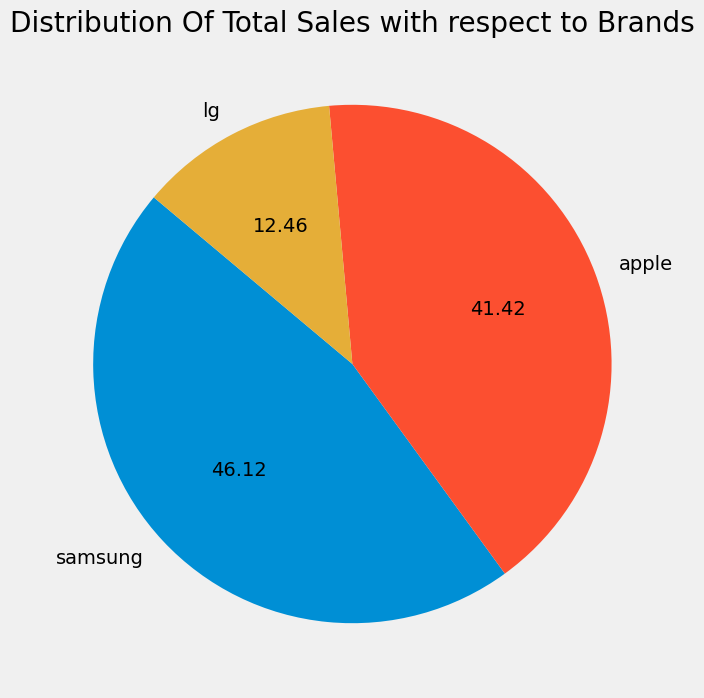

In [69]:
plt.figure(figsize=(17,8))
plt.pie(total_sales['Percentage Of Total Sales'],labels=total_sales['brand'],autopct='%.2f',startangle=140)
plt.title("Distribution Of Total Sales with respect to Brands")
plt.show()

Top 3 Brands Account for 48% overall sales with samsung having 55% approx shares in revenue.

14.What is the correlation between product price and purchase frequency?
Explanation: Analyze whether higher-priced products are purchased more or less frequently.

In [70]:
# Calculate purchase frequency for each product
product_stats = df.groupby('product_id').agg(purchase_frequency=('product_id', 'count'),average_price=('price', 'mean')).reset_index()
# Calculate correlation between price and purchase frequency
correlation = product_stats['average_price'].corr(product_stats['purchase_frequency'])
# Display the results
print(product_stats)
print(f"Correlation between price and purchase frequency: {correlation:.2f}")


                product_id  purchase_frequency  average_price
0      1515966223509088493                 417         740.72
1      1515966223509088496                 161         266.18
2      1515966223509088497                 424        1215.25
3      1515966223509088498                 479         115.72
4      1515966223509088499                  78         601.83
...                    ...                 ...            ...
18621  2388434452476865703                   1        1712.94
18622  2388434452476875362                   2          66.18
18623  2388434452476876268                   1          76.37
18624  2388434452476879177                   1          73.13
18625  2388434452476881700                   1          92.57

[18626 rows x 3 columns]
Correlation between price and purchase frequency: 0.01


15.How does the total revenue split across categories and brands?
Explanation: Create a grouped analysis to compare revenue by both categories and brands.

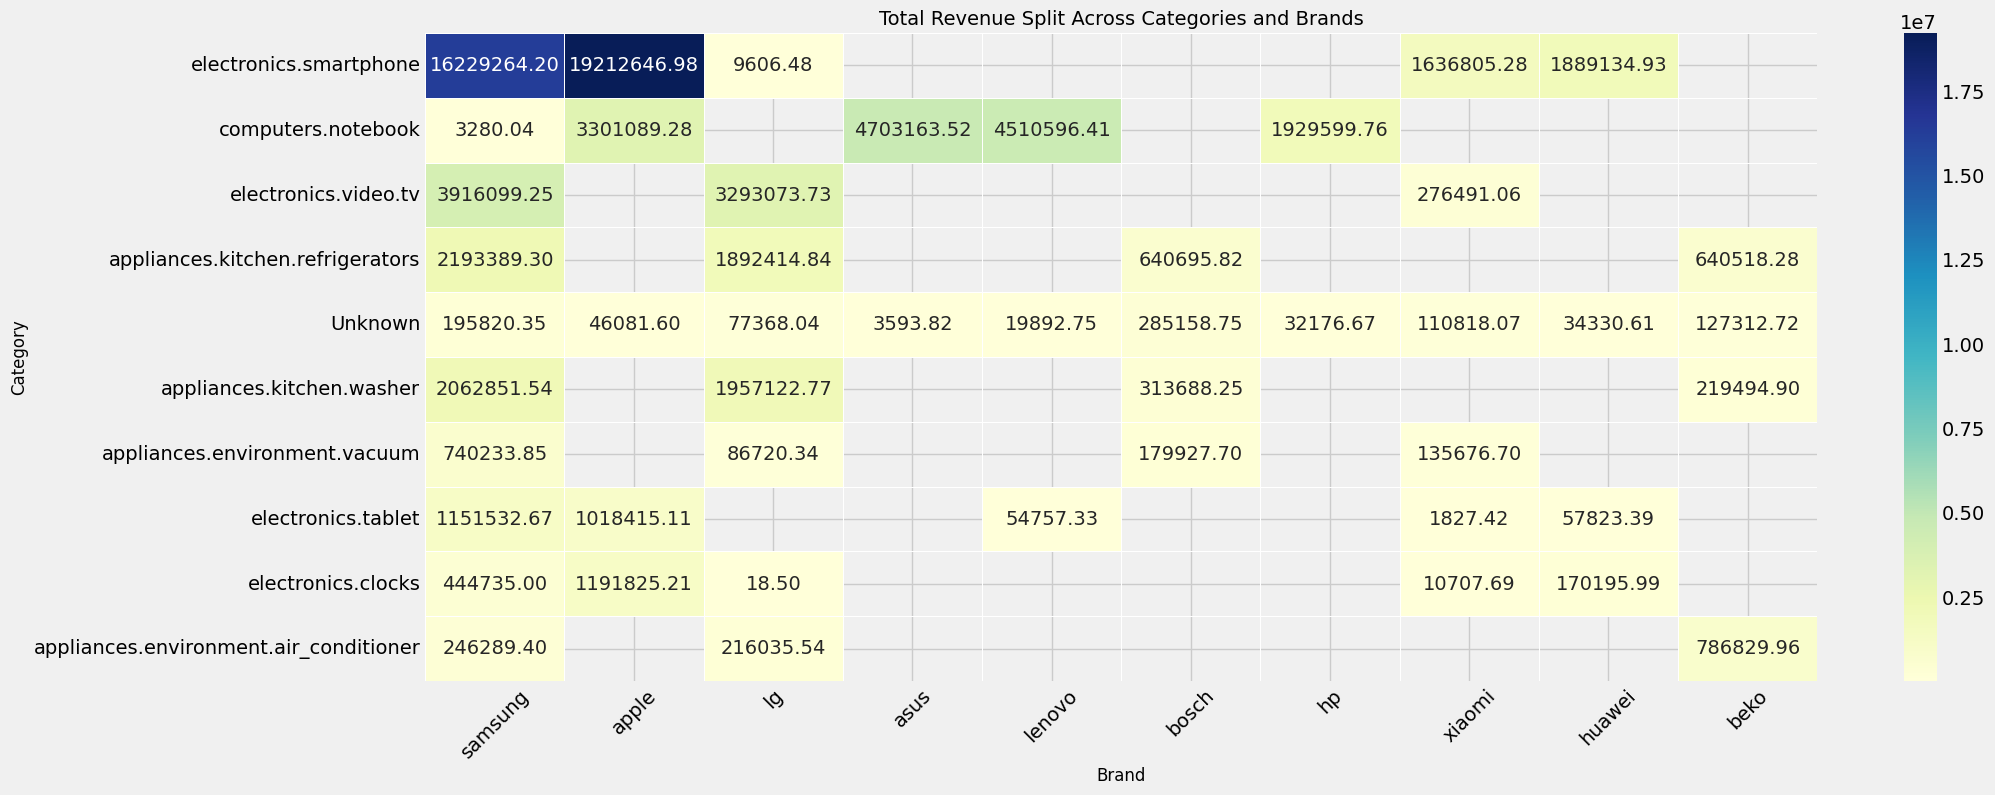

In [71]:
revenue_split = df.groupby(['category_code', 'brand'])['price'].sum().reset_index()
pivot_table = revenue_split.pivot(index='category_code', columns='brand', values='price')
top_categories=pivot_table.sum(axis=1).nlargest(10).index
top_brands=pivot_table.sum(axis=0).nlargest(10).index
filtered_data=pivot_table.loc[top_categories, top_brands]
plt.figure(figsize=(20, 8))
sns.heatmap(filtered_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Total Revenue Split Across Categories and Brands", fontsize=14)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

 Electronics.smartphone dominates the revenue across multiple brands, with significant contributions from Samsung, Apple.
 Samsung and Apple are the largest contributors across the board, with notable revenue in smartphones and TVs.

## Label Encoding Of Categorical Variables 

In [72]:
df1=df[cat_col].apply(LabelEncoder().fit_transform)

In [73]:
df1.head()

,category_code,brand,Segment,Sub-Segment
0,90,660,8,102
1,90,660,8,102
2,82,344,8,9
3,82,344,8,9
4,0,398,0,0


In [74]:
df2=df1.join(df[num_col])
df2.head()

,category_code,brand,Segment,Sub-Segment,order_id,product_id,category_id,price,user_id,hour
0,90,660,8,102,2294359932054536986,1515966223509089906,2268105426648171008,162.01,1515915625441993984,11
1,90,660,8,102,2294359932054536986,1515966223509089906,2268105426648171008,162.01,1515915625441993984,11
2,82,344,8,9,2294444024058086220,2273948319057183658,2268105430162997760,77.52,1515915625447879424,14
3,82,344,8,9,2294444024058086220,2273948319057183658,2268105430162997760,77.52,1515915625447879424,14
4,0,398,0,0,2294584263154074236,2273948316817424439,2268105471367840000,217.57,1515915625443148032,19


In [75]:
df2.shape

(526683, 10)

**Scaling using Standard Scaler**

In [76]:
x=df2.drop('category_code',axis=1)
y=df[['category_code']]

In [77]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
x2=ss.fit_transform(x)
x2


array([[ 8.47605869e-01,  1.03471543e+00,  1.19962995e+00, ...,
        -1.78489827e-01, -4.41794560e+07,  3.51124558e-01],
       [ 8.47605869e-01,  1.03471543e+00,  1.19962995e+00, ...,
        -1.78489827e-01, -4.41794560e+07,  3.51124558e-01],
       [-3.69186886e-01,  1.03471543e+00, -1.19978734e+00, ...,
        -4.53048917e-01, -3.82940160e+07,  1.06375933e+00],
       ...,
       [ 1.39824310e+00, -4.67535400e-01,  8.90027720e-01, ...,
        -6.64403198e-01,  2.86607360e+07,  1.13579635e-01],
       [ 2.77715592e-01, -1.36888590e+00, -1.43198902e+00, ...,
        -5.69644729e-01,  2.86607360e+07,  1.13579635e-01],
       [ 7.24386350e-01, -4.67535400e-01, -3.87789752e-02, ...,
        -5.32014308e-01,  2.86607360e+07,  1.13579635e-01]],
      shape=(526683, 9))

## Train Test Split

In [78]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(x2,y,test_size=0.3,random_state=1)

Predictive model 1: Logistic regression¶

In [84]:
lr=LogisticRegression()

In [80]:
lr.fit(x_train,y_train)

LogisticRegression()

In [81]:
y_pred=lr.predict(x_test)

In [82]:
print(classification_report(y_test,y_pred))

                                        precision    recall  f1-score   support

                               Unknown       0.43      1.00      0.60     34256
                       accessories.bag       0.00      0.00      0.00       912
                  accessories.umbrella       0.00      0.00      0.00         2
                         apparel.glove       0.00      0.00      0.00       604
                         apparel.shirt       0.00      0.00      0.00        75
                          apparel.sock       0.00      0.00      0.00        12
                      apparel.trousers       0.00      0.00      0.00        26
                        apparel.tshirt       0.00      0.00      0.00       103
appliances.environment.air_conditioner       0.00      0.00      0.00      2282
     appliances.environment.air_heater       0.00      0.00      0.00       775
        appliances.environment.climate       0.00      0.00      0.00        35
            appliances.environment.fan 

confusion_matrix(y_pred,y_test)

In [98]:
x_train=pd.DataFrame(x_train)

In [118]:
x_test=pd.DataFrame(x_test)

**Use RFE to select top n features**

In [85]:
from sklearn.feature_selection import RFE
rfe=RFE(estimator=lr,n_features_to_select= 5)
rfe.fit(x_train,y_train)
print("Selected Features (support_):", rfe.support_)
print("Feature Ranking (ranking_):", rfe.ranking_)


Selected Features (support_): [ True  True  True False False  True  True False False]
Feature Ranking (ranking_): [1 1 1 3 2 1 1 5 4]


In [116]:
print(x_test.shape[1])

9


In [117]:
x_train.columns[rfe.support_]


Index([0, 1, 2, 5, 6], dtype='int64')

In [105]:
col=x_train.columns[rfe.support_]


In [108]:
lr.fit(x_train[col],y_train)


LogisticRegression()

In [119]:
y_Pred2 = lr.predict(x_test[col])


In [120]:
print(classification_report(y_Pred2,y_test))


                                        precision    recall  f1-score   support

                               Unknown       1.00      1.00      1.00     34261
                       accessories.bag       0.99      1.00      1.00       907
                  accessories.umbrella       0.00      0.00      0.00         0
                         apparel.glove       0.98      1.00      0.99       590
                         apparel.shirt       1.00      1.00      1.00        75
                          apparel.sock       0.00      0.00      0.00         0
                      apparel.trousers       0.00      0.00      0.00         0
                        apparel.tshirt       1.00      0.80      0.89       129
appliances.environment.air_conditioner       0.91      0.98      0.95      2118
     appliances.environment.air_heater       0.40      0.80      0.54       389
        appliances.environment.climate       0.00      0.00      0.00         0
            appliances.environment.fan 

In [121]:
confusion_matrix(y_Pred2,y_test)

array([[34256,     5,     0, ...,     0,     0,     0],
       [    0,   907,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,   711,     0,     0],
       [    0,     0,     0, ...,     0,   282,     0],
       [    0,     0,     0, ...,     0,     0,     0]], shape=(121, 121))

**Predictive model 2: Random Forest**

In [124]:
RFC = RandomForestClassifier(max_depth=5,random_state=0,max_leaf_nodes=50)

In [125]:
RFC

RandomForestClassifier(max_depth=5, max_leaf_nodes=50, random_state=0)

In [126]:
RFC.fit(x_train,y_train)

RandomForestClassifier(max_depth=5, max_leaf_nodes=50, random_state=0)

In [ ]:
cv1_score= cross_val_score(RFC,x_train,y_train, cv=5)
np.mean(cv1_score)

In [ ]:
Y_pred_= RFC.predict(x_test)

In [ ]:
print(classification_report(y_test, Y_pred_))

In [ ]:
f1_score(y_test,Y_pred_)

In [ ]:
roc_auc_score(y_test,Y_pred_)

**RFE**

In [ ]:
rfe1 = RFE(RFC, 5)
rfe1.fit(x_train,y_train)

In [ ]:
rfe1.support_

In [ ]:
x_train.columns[rfe1.support_]


In [ ]:
cols=x_train.columns[rfe1.support_]


In [ ]:
RFC.fit(x_train[cols],y_train)


In [ ]:
y_pred2=RFC.predict(x_test[cols])

In [ ]:
f1_score(y_pred2,y_test)

In [ ]:
confusion_matrix(y_pred2,y_test)

In [ ]:
print(classification_report(y_pred2, y_test))

In [ ]:
roc_auc_score(y_test,y_pred2)